# **Where's Waldo: Template Matching Project**

Selecting an image

In [ ]:
!pip install ipywidgets opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


Saving test2.png to test2 (2).png


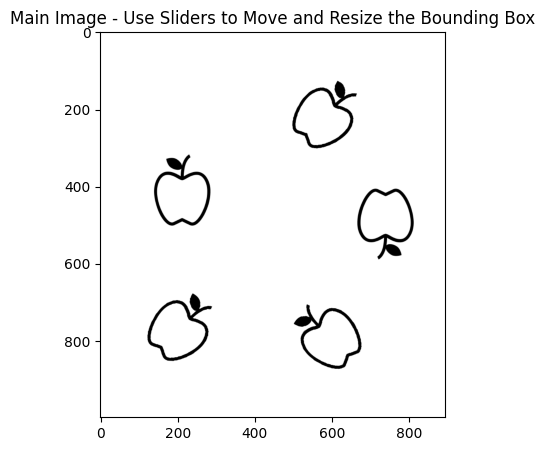

Output()

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from ipywidgets import widgets
from IPython.display import display

# Upload the main image
uploaded = files.upload()
main_image_path = list(uploaded.keys())[0]  # Get the uploaded file name
main_image = cv2.imread(main_image_path)
main_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)

# Display the main image with reduced size
plt.figure(figsize=(5, 5))
plt.imshow(main_image_rgb)
plt.title('Main Image - Use Sliders to Move and Resize the Bounding Box')
plt.show()

# Function to draw the adjustable bounding box
def hover_crop(x, y, box_width, box_height):
    # Create a copy of the image to draw the bounding box
    image_with_box = main_image_rgb.copy()

    # Draw the bounding box on the image copy
    top_left = (x, y)
    bottom_right = (x + box_width, y + box_height)
    cv2.rectangle(image_with_box, top_left, bottom_right, (255, 0, 0), 2)

    # Display the image with the bounding box
    plt.figure(figsize=(5, 5))
    plt.imshow(image_with_box)
    plt.title('Hovering with Adjustable Bounding Box')
    plt.show()

# Create sliders to move and resize the bounding box
x_slider = widgets.IntSlider(min=0, max=main_image.shape[1] - 1, step=1, description='X:')
y_slider = widgets.IntSlider(min=0, max=main_image.shape[0] - 1, step=1, description='Y:')
width_slider = widgets.IntSlider(min=1, max=main_image.shape[1], step=1, value=100, description='Width:')
height_slider = widgets.IntSlider(min=1, max=main_image.shape[0], step=1, value=100, description='Height:')

# Interactive display
ui = widgets.VBox([x_slider, y_slider, width_slider, height_slider])
out = widgets.interactive_output(hover_crop, {'x': x_slider, 'y': y_slider, 'box_width': width_slider, 'box_height': height_slider})
display(ui, out)


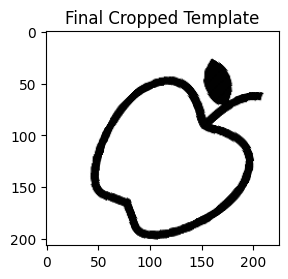

In [45]:
# Capture the cropped area based on the slider values
x_val, y_val = x_slider.value, y_slider.value
box_width_val = width_slider.value  # Get the current width from the slider
box_height_val = height_slider.value  # Get the current height from the slider

# Crop the template based on the selected values
template = main_image[y_val:y_val + box_height_val, x_val:x_val + box_width_val]

# Display the final cropped template to confirm
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Final Cropped Template')
plt.show()


In [ ]:
# plt.imshow(main_image_rgb)
#  plt.title('Main Image')

Multi Scale Template Matching Process

In [14]:
main_image_path = '/content/crowd2.jpg'
template_path = '/content/crowd2_template.jpg'

main_image = cv2.imread(main_image_path)
main_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

template = cv2.imread(template_path)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)  # Convert to RGB

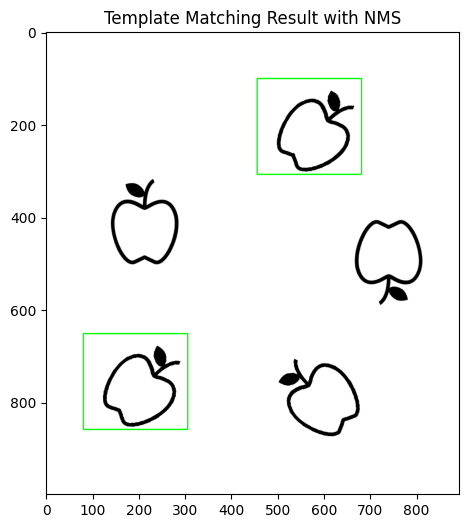

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters
scale_steps = 10  # Number of scales to try
threshold = 0.8   # Only consider matches with a score above this threshold

# Convert images to grayscale
main_image_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
w, h = template_gray.shape[::-1]  # Template width and height

# List to store all detected match locations
all_matches = []
all_scores = []

# Multi-scale matching
for scale in np.linspace(0.5, 2.0, scale_steps):  # Try scales from 50% to 200%
    resized_main_image = cv2.resize(main_image_gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

    # Skip if the resized image is smaller than the template
    if resized_main_image.shape[0] < h or resized_main_image.shape[1] < w:
        continue

    # Template matching
    result = cv2.matchTemplate(resized_main_image, template_gray, cv2.TM_CCOEFF_NORMED)

    # Find locations above the threshold
    loc = np.where(result >= threshold)

    # Save the locations, scale factor, and match score
    for pt in zip(*loc[::-1]):  # Switch x, y for each location
        all_matches.append((int(pt[0] / scale), int(pt[1] / scale), int(w / scale), int(h / scale)))
        all_scores.append(result[pt[1], pt[0]])

# Apply Non-Maximum Suppression (NMS)
def non_max_suppression(boxes, scores, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    # Compute area of the boxes and sort by score
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]

    pick = []
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)

        # Find overlap
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        # Compute width and height of overlap
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[1:]]

        # Delete indexes that overlap too much
        idxs = np.delete(idxs, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1)))

    return boxes[pick].astype("int")

# Filter matches using NMS
filtered_boxes = non_max_suppression(all_matches, all_scores)

# Draw rectangles for filtered matches
main_image_copy = main_image_rgb.copy()  # Make a copy to avoid redrawing

for (x, y, w, h) in filtered_boxes:
    cv2.rectangle(main_image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result with multiple matches after NMS
plt.figure(figsize=(6, 6))
plt.imshow(main_image_copy)
plt.title('Template Matching Result with NMS')
plt.show()


# **Rotation Invariatn Implementation**

In [7]:
main_image_path = '/content/crowd.jpeg'
template_path = '/content/crowd_template.jpeg'

main_image = cv2.imread(main_image_path)
main_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

template = cv2.imread(template_path)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)  # Convert to RGB


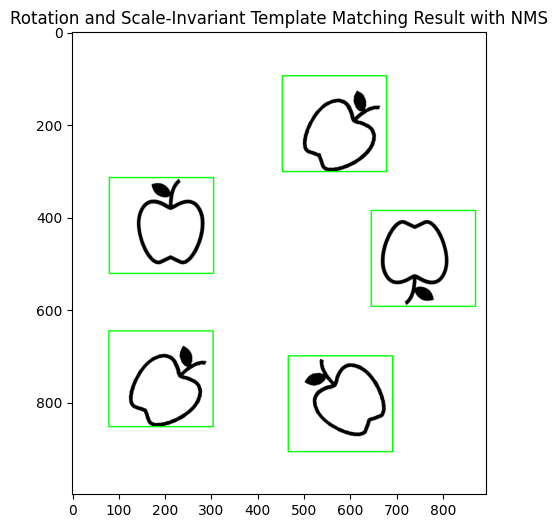

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the function from InvariantTM.py
from InvariantTM import invariant_match_template  # Uncomment if running locally

# Define parameters for rotation and scale invariant matching
rot_range = [0, 360]           # Full rotation range to cover all angles
rot_interval = 1               # Rotate every 1 degree for fine granularity
scale_range = [50, 150]        # Scale from 50% to 150%
scale_interval = 10            # Scale increment of 10%
matched_thresh = 0.5           # Threshold for matching; adjust if needed
method = "TM_CCOEFF_NORMED"    # Template matching method
rm_redundant = True            # Remove redundant matches within function
minmax = False                 # Min/Max matching

# Run the invariant template matching
matches = invariant_match_template(main_image_rgb, template, method, matched_thresh,
                                   rot_range, rot_interval, scale_range, scale_interval,
                                   rm_redundant, minmax)

# Define the Non-Maximum Suppression (NMS) function
def non_max_suppression(matches, overlap_thresh=0.3):
    if len(matches) == 0:
        return []

    boxes = []
    for match in matches:
        pt, angle, scale = match[:3]
        w, h = int(template.shape[1] * scale / 100), int(template.shape[0] * scale / 100)
        boxes.append([pt[0], pt[1], w, h])

    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype("int")

# Apply NMS to the matches
filtered_boxes = non_max_suppression(matches, overlap_thresh=0.5)

# Draw rectangles for filtered matches
main_image_copy = main_image_rgb.copy()  # Make a copy to avoid redrawing

for (x, y, w, h) in filtered_boxes:
    cv2.rectangle(main_image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result with NMS applied
plt.figure(figsize=(6, 6))
plt.imshow(main_image_copy)
plt.title("Rotation and Scale-Invariant Template Matching Result with NMS")
plt.show()


# **Testing Rotation method on different images**

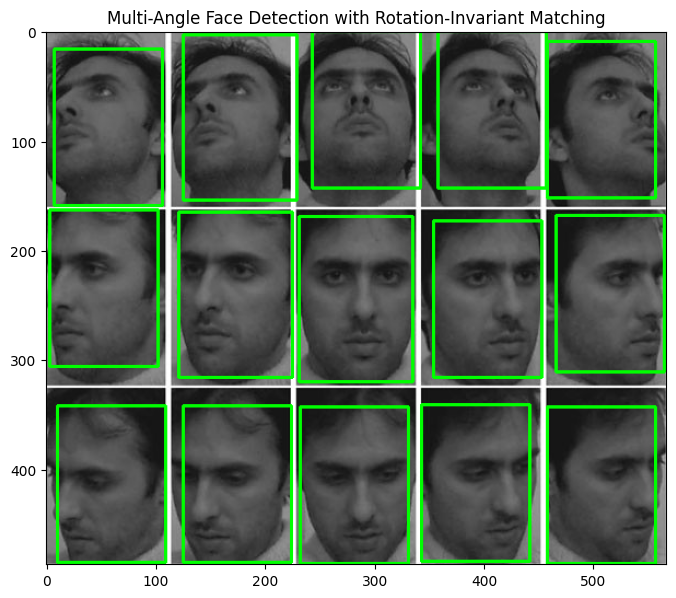

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from InvariantTM import invariant_match_template  # Uncomment if running locally

# Load the main image and templates
main_image = cv2.imread("rotation_test.jpg")  # Replace with the path to your main image
main_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
templates = [
    cv2.imread("rotation_test_left.jpg", cv2.IMREAD_GRAYSCALE),
    cv2.imread("rotation_test_straight.jpg", cv2.IMREAD_GRAYSCALE),
    cv2.imread("rotation_test_right.jpg", cv2.IMREAD_GRAYSCALE)
]

# Parameters for rotation and scale invariant matching
rot_range = [-15, 15]         # Rotate each template within a ±15-degree range
rot_interval = 1              # Rotate every 5 degrees for finer granularity
scale_range = [90, 110]       # Scale from 90% to 110% of the original size
scale_interval = 5            # Scale increment of 5%
matched_thresh = 0.35          # Threshold for template matching; adjust if needed
method = "TM_CCOEFF_NORMED"   # Template matching method
rm_redundant = True           # Remove redundant matches within function
minmax = False                # Min/Max matching

# Initialize an empty list to store all matches from different rotations
all_matches = []

# Convert grayscale templates to RGB before passing to the function
templates_rgb = [cv2.cvtColor(template, cv2.COLOR_GRAY2RGB) if len(template.shape) == 2 else template for template in templates]

# Perform rotation-invariant matching for each template
all_matches = []
for template in templates_rgb:
    matches = invariant_match_template(
        main_image_rgb, template, method, matched_thresh,
        rot_range, rot_interval, scale_range, scale_interval,
        rm_redundant, minmax
    )
    all_matches.extend(matches)  # Add matches to the list


# Define Non-Maximum Suppression (NMS) to remove overlapping boxes
def non_max_suppression(matches, overlap_thresh=0.3):
    if len(matches) == 0:
        return []

    boxes = []
    for match in matches:
        pt, angle, scale = match[:3]
        w, h = int(template.shape[1] * scale / 100), int(template.shape[0] * scale / 100)
        boxes.append([pt[0], pt[1], w, h])

    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype("int")

# Apply NMS to all collected matches
filtered_boxes = non_max_suppression(all_matches, overlap_thresh=0.5)

# Draw rectangles for filtered matches
main_image_copy = main_image_rgb.copy()  # Make a copy to avoid redrawing

for (x, y, w, h) in filtered_boxes:
    cv2.rectangle(main_image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result with NMS applied
plt.figure(figsize=(8, 8))
plt.imshow(main_image_copy)
plt.title("Multi-Angle Face Detection with Rotation-Invariant Matching")
plt.show()


# **YOLOv5 Implementation**

In [3]:
# Cloning Yolov5 repo
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 37.75 MiB/s, done.
Resolving deltas: 100% (11705/11705), done.
/content/yolov5/yolov5


In [4]:
!pip install -r requirements.txt      #Installing dependenceis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 16.0 MB/s eta 0:00:00


In [5]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available


True


In [7]:
#Installing COCO dataset
!bash data/scripts/get_coco.sh


############################################################################################# 100.0%
replace ../datasets/coco/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
############################################################################################# 100.0%
replace ../datasets/coco/images/val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
############################################################################################# 100.0%
replace ../datasets/coco/images/train2017/000000147328.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [8]:
#Training YOLOv5 with COCO
!python train.py --img 640 --batch 16 --epochs 50 --data coco128.yaml --weights yolov5s.pt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-16 18:39:39.527335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 18:39:39.841464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 18:39:39.935712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [9]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --source data/images/


detect: weights=['runs/train/exp/weights/best.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/2 /content/yolov5/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 2 handbags, 27.5ms
image 2/2 /content/yolov5/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, 28.1ms
Speed: 0.5ms pre-process, 27.8ms inference, 242.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


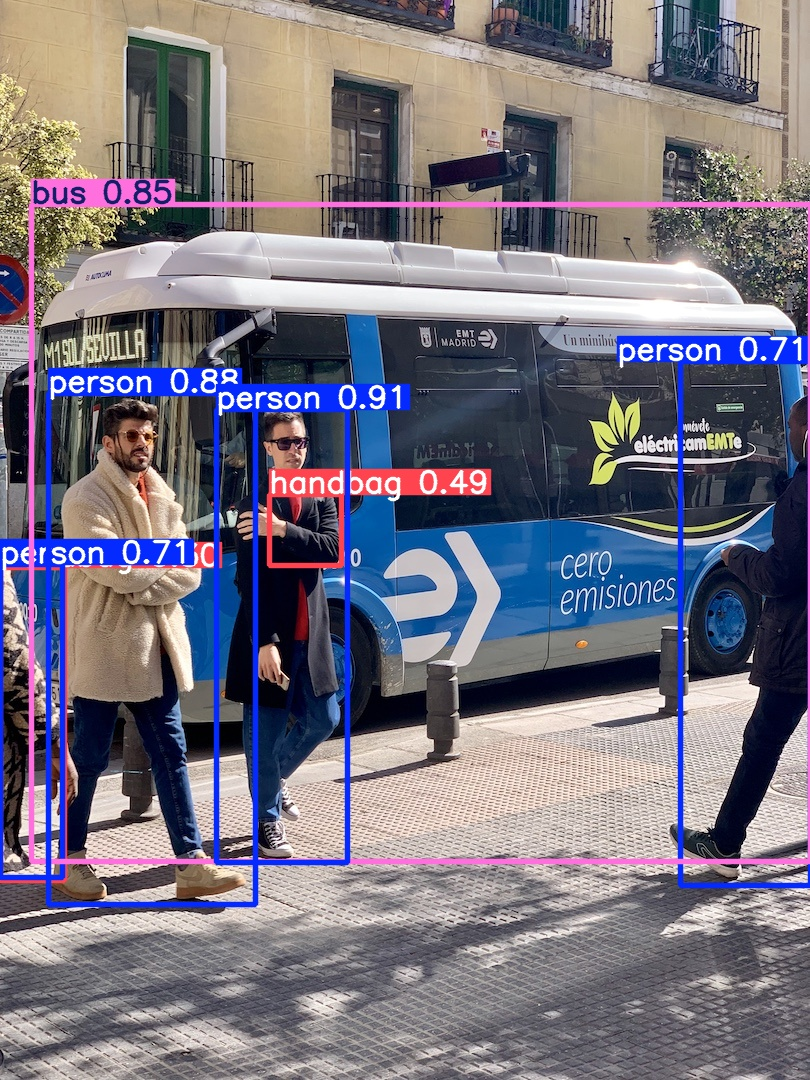

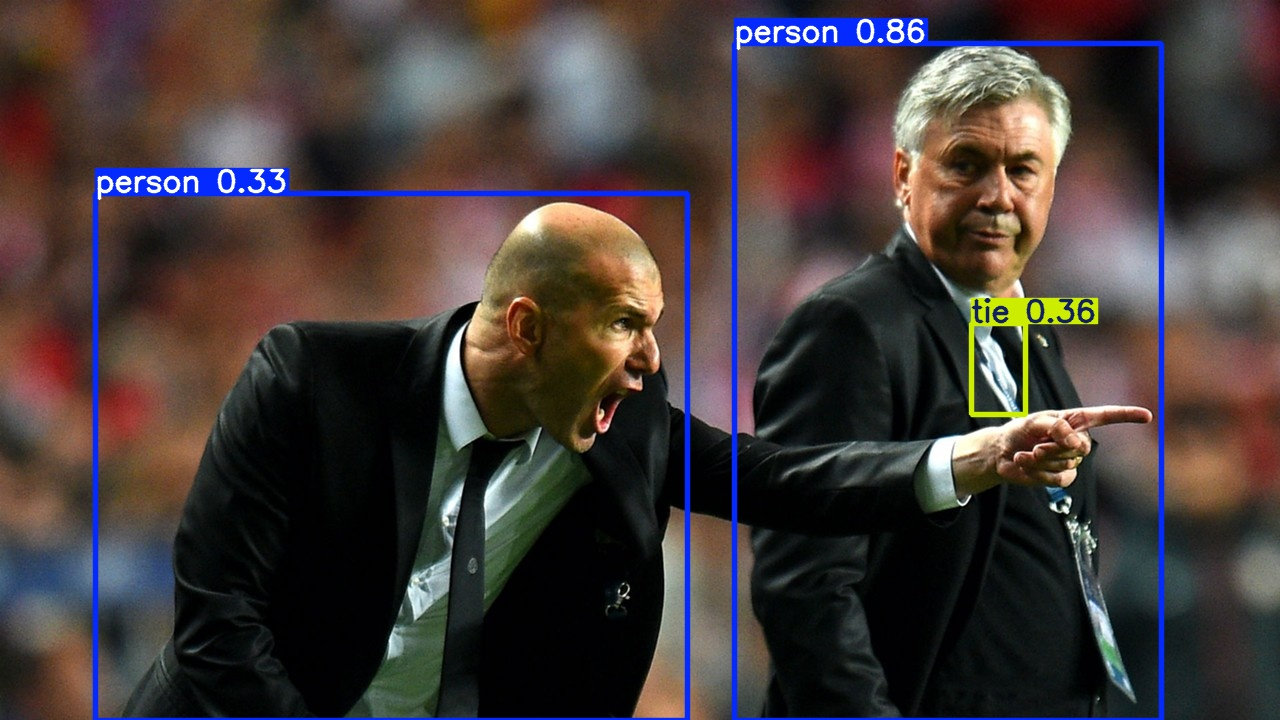

In [10]:
import glob
from IPython.display import Image, display

image_list = glob.glob('runs/detect/exp/*.jpg')
for image_path in image_list:
    display(Image(filename=image_path))


In [11]:
from google.colab import drive
drive.mount('/content/drive')
!cp runs/train/exp/weights/best.pt /content/drive/MyDrive/CV/


Mounted at /content/drive


In [12]:
from google.colab import files
files.download('runs/train/exp/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
from google.colab import files
uploaded = files.upload()  # This will allow you to upload your local image


Saving watch.jpg to watch.jpg


In [83]:
!cp /content/drive/MyDrive/CV/watch.jpg /content/yolov5/


In [84]:
!python detect.py --weights yolov5s.pt --img 640 --source watch.jpg


detect: weights=['yolov5s.pt'], source=watch.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/yolov5/watch.jpg: 640x480 1 suitcase, 1 mouse, 1 clock, 28.7ms
Speed: 0.6ms pre-process, 28.7ms inference, 606.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp12


In [85]:
!ls runs/detect/exp12

watch.jpg


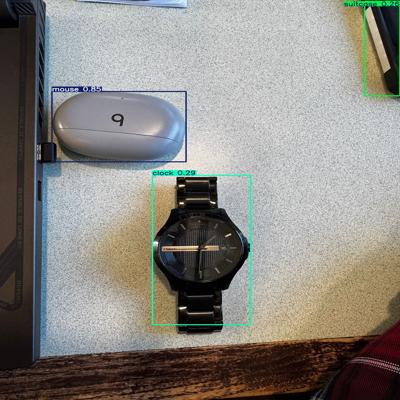

In [86]:
from IPython.display import Image, display
from PIL import Image as PILImage

# Load and resize the image before displaying
image_path = 'runs/detect/exp12/watch.jpg'
with PILImage.open(image_path) as img:
    resized_img = img.resize((400, 400))  # Resize to width=800, height=600 or any preferred dimensions
    resized_img.save('resized_man.jpg')  # Save the resized image

# Display the resized image
display(Image(filename='resized_man.jpg'))


# **Occlusion Handling using YOLOv5**



In [75]:
# Training using a different YOLOv5 model (e.g., yolov5m.pt)
!python train.py --img 640 --batch 16 --epochs 50 --data coco128.yaml --weights yolov5m.pt


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-16 19:21:40.896413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 19:21:40.917209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 19:21:40.923614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-11-16 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


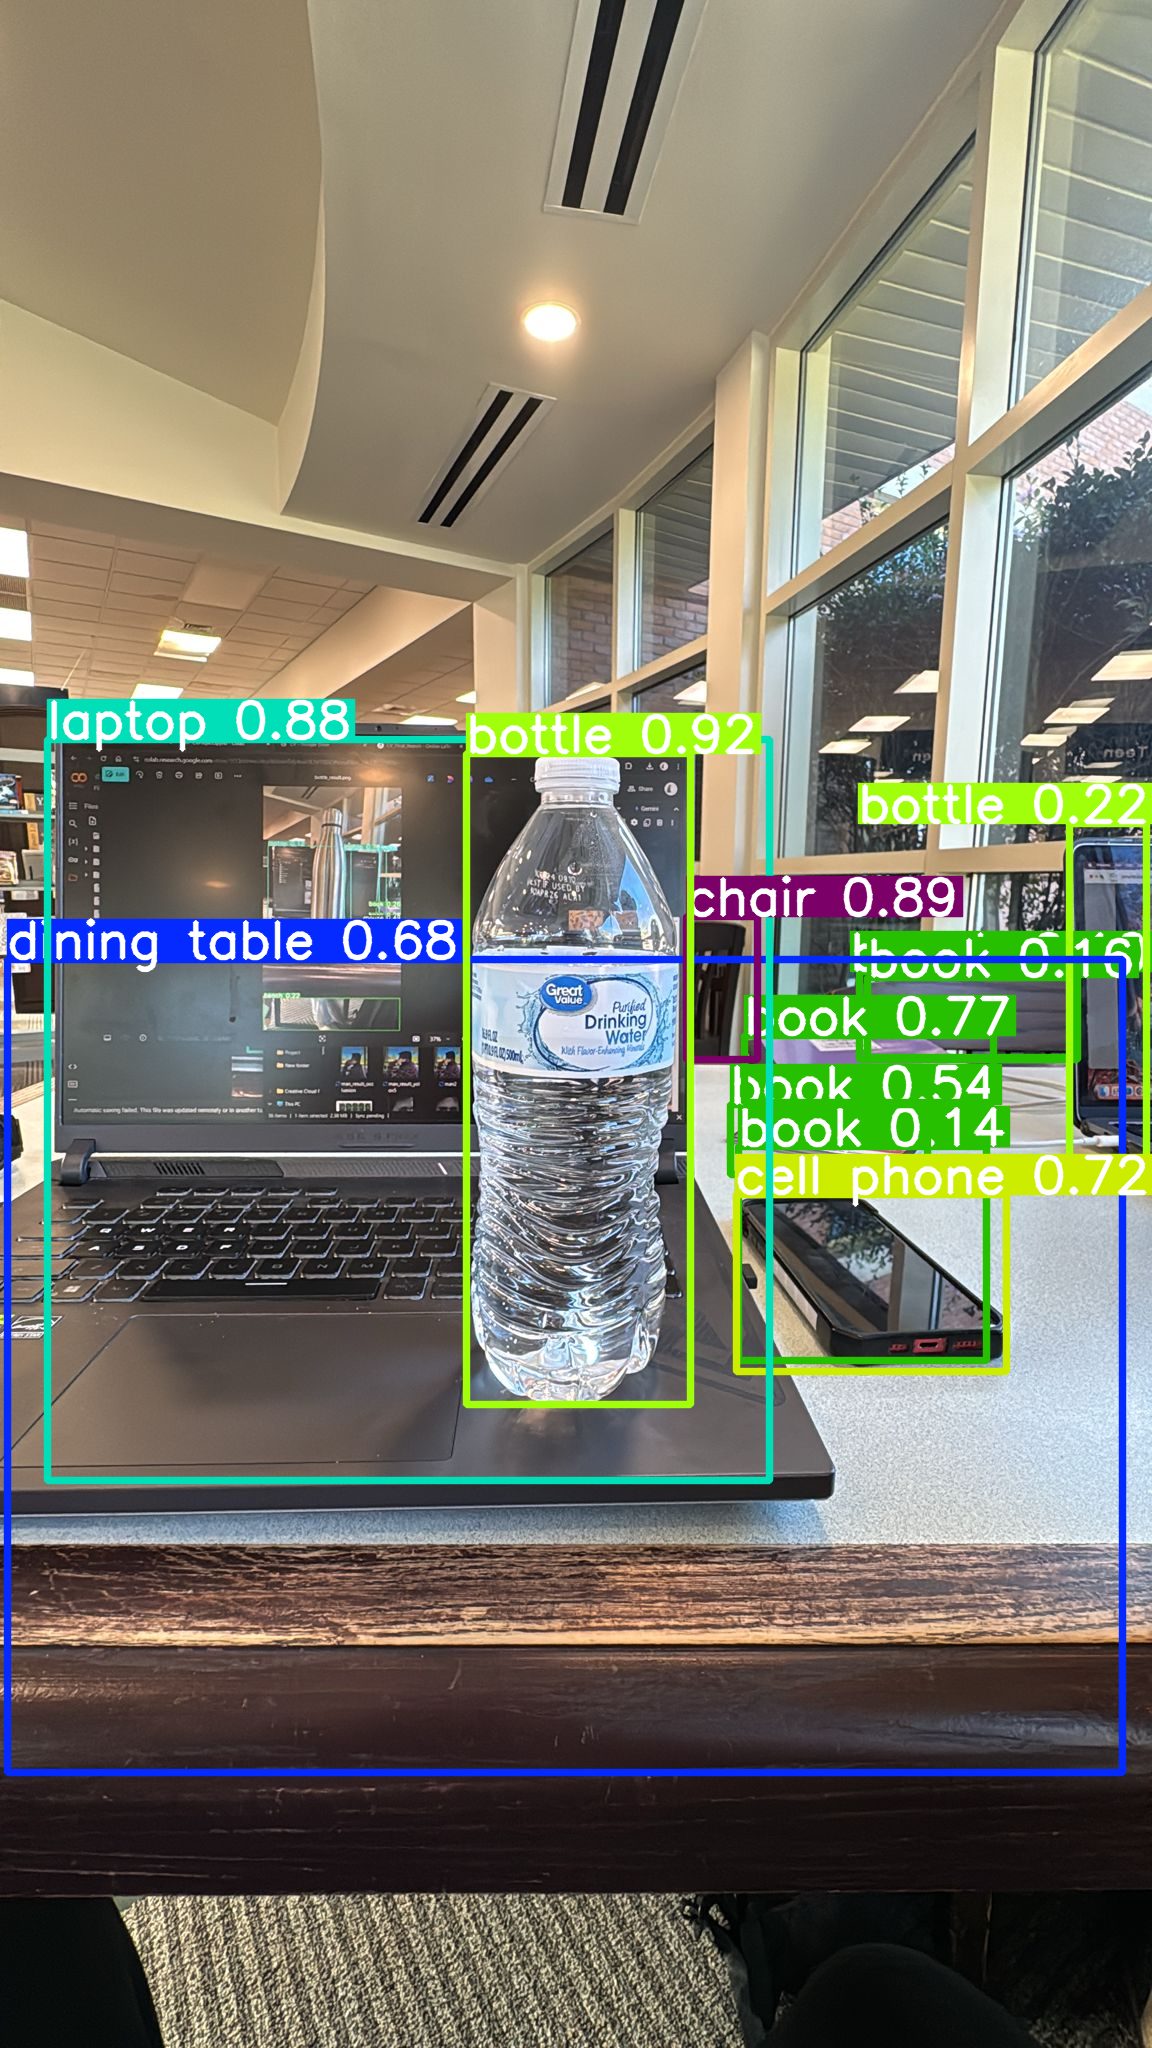

Objects detected! Proceeding with occlusion handling...


In [89]:
import torch
from PIL import Image

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True)

# Set the confidence threshold to a lower value
model.conf = 0.1  # Set the confidence threshold to 0.3 to detect more objects, even if not highly confident

# Load the image path (update this to match the uploaded file name)
image_path = '/content/bottle2.jpg'

# Run YOLOv5 inference
results = model(image_path)

# Show detection results to see if it detects the football
results.show()

# Extract the bounding boxes detected by YOLOv5
bboxes = results.xyxy[0]  # xyxy format: [x_min, y_min, x_max, y_max, confidence, class]

if len(bboxes) > 0:
    print("Objects detected! Proceeding with occlusion handling...")
else:
    print("No objects detected in the image to use as a template.")


In [97]:
import torch
from PIL import Image as PILImage
from IPython.display import display

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True)

# Set the confidence threshold to a lower value
model.conf = 0.1  # Set the confidence threshold to 0.1 to detect more objects, even if not highly confident

# Set the model to detect only laptops (COCO class 63)
model.classes = [63]  # COCO class for "laptop"

# Load the image path
image_path = '/content/bottle2.jpg'

# Run YOLOv5 inference
results = model(image_path)

# Save the output result to a file (so we can resize it)
results.save()

# Resize the saved result to make it easier to visualize



Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-11-16 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to runs/detect/exp16


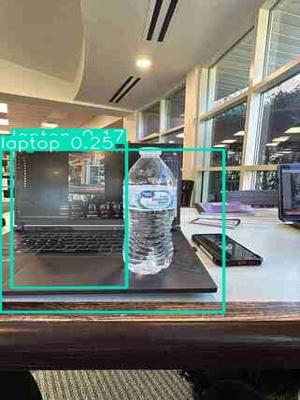

Laptop detected! Proceeding with occlusion handling...


In [98]:
output_image_path = 'runs/detect/exp16/bottle2.jpg'  # Make sure this path matches where YOLOv5 saved your result
with PILImage.open(output_image_path) as img:
    resized_img = img.resize((300, 400))  # Resize to preferred dimensions (width=600, height=400)
    resized_img.save('resized_bottle2.jpg')  # Save the resized image

# Display the resized image
display(PILImage.open('resized_bottle2.jpg'))

# Extract the bounding boxes detected by YOLOv5
bboxes = results.xyxy[0]  # xyxy format: [x_min, y_min, x_max, y_max, confidence, class]

if len(bboxes) > 0:
    print("Laptop detected! Proceeding with occlusion handling...")
else:
    print("No laptops detected in the image.")

Real-Time Detection

In [ ]:
import torch
import cv2
from google.colab import files

# Step 1: Upload a video file
uploaded = files.upload()
video_path = list(uploaded.keys())[0]  # Get the uploaded video filename

# Step 2: Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True)

# Step 3: Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object to save output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (width, height))

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    while cap.isOpened():
        ret, frame = cap.read()

        # Break the loop if no frames are returned
        if not ret:
            break

        # Step 4: Perform inference on each frame
        results = model(frame)

        # Extract results and draw bounding boxes on the frame
        for det in results.xyxy[0]:  # xyxy format: [x_min, y_min, x_max, y_max, confidence, class]
            x_min, y_min, x_max, y_max, conf, cls = list(map(int, det[:4])) + [float(det[4]), int(det[5])]
            label = f"{model.names[cls]} {conf:.2f}"
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Write the processed frame to the output video file
        out.write(frame)

    # Release the video capture and video write objects
    cap.release()
    out.release()

    print("Processing complete. The output video is saved as 'output_video.mp4'.")
